**Read the csv files**

In [1]:
# Reading the csv files
bike_share_train <- read.csv("../input/train.csv")
bike_share_test <- read.csv("../input/test.csv")

str(bike_share_train)
#head(bike_share_train)

'data.frame':	10886 obs. of  12 variables:
 $ datetime  : Factor w/ 10886 levels "2011-01-01 00:00:00",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weather   : int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ count     : int  16 40 32 13 1 1 2 3 8 14 ...


**Feature Engineering**

In [2]:
# Ignore the casual, registered fields as this sum is equal to count field
bike_share_train <- bike_share_train[,-c(10,11)]

# Converting integer to factor on training set
bike_share_train$season <- as.factor(bike_share_train$season)
bike_share_train$holiday <- as.factor(bike_share_train$holiday)
bike_share_train$workingday <- as.factor(bike_share_train$workingday)
bike_share_train$weather <- as.factor(bike_share_train$weather)
bike_share_train$datetime <-as.POSIXct(bike_share_train$datetime, format="%Y-%m-%d %H:%M:%S")

# Converting int to factor on test set
bike_share_test$season <- as.factor(bike_share_test$season)
bike_share_test$holiday <- as.factor(bike_share_test$holiday)
bike_share_test$workingday <- as.factor(bike_share_test$workingday)
bike_share_test$weather <- as.factor(bike_share_test$weather)
bike_share_test$datetime <-as.POSIXct(bike_share_test$datetime, format="%Y-%m-%d %H:%M:%S")

# Extract day from datetime value
bike_share_train$day <-  strftime(bike_share_train$datetime, '%u')
bike_share_train$day <- as.factor(bike_share_train$day)
bike_share_test$day <-  strftime(bike_share_test$datetime, '%u')
bike_share_test$day <- as.factor(bike_share_test$day)


# Extract hour from datetime value
bike_share_train$hour <- substring(bike_share_train$datetime, 12,13)
bike_share_train$hour <- as.factor(bike_share_train$hour)
bike_share_test$hour <- substring(bike_share_test$datetime, 12,13)
bike_share_test$hour <- as.factor(bike_share_test$hour)

# Removing datetime field 
bike_share_train <- bike_share_train[,-1]

**Exploratory Data Analysis**

Loading required package: gsubfn
Loading required package: proto
Warning message:
“no DISPLAY variable so Tk is not available”Loading required package: RSQLite


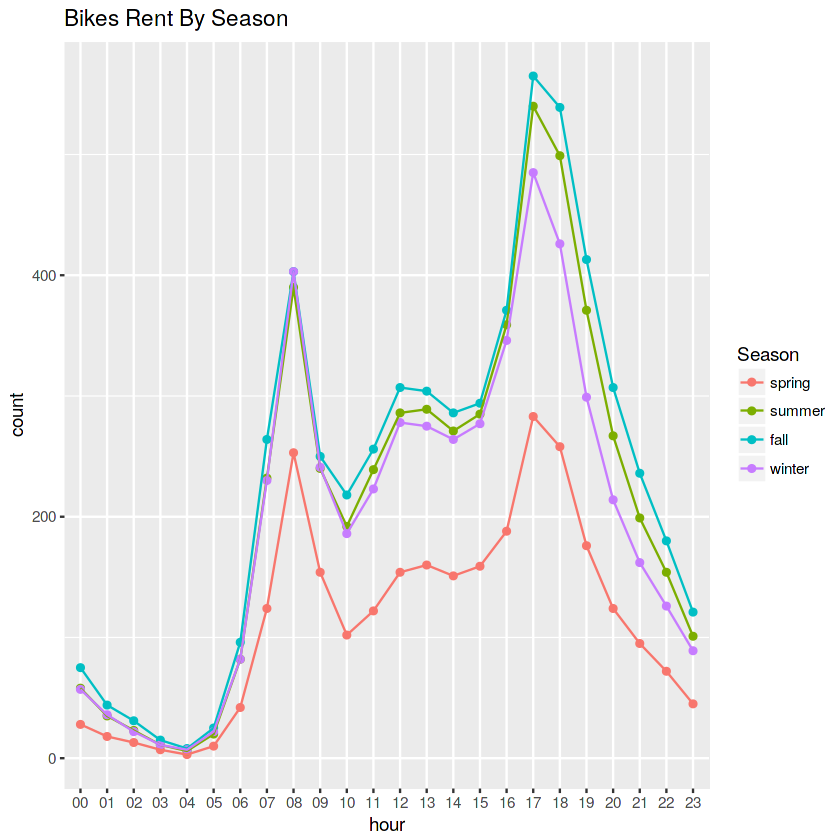

In [3]:
library(sqldf)
library(ggplot2)
# Get the average count of bikes rent by season, hour
season_summary_by_hour <- sqldf('select season, hour, avg(count) as count from bike_share_train group by season, hour')

# From this plot it shows, 
# There are more rental in morning(from 7-9th hour) and evening(16-19th hour)
# People rent bikes more in Fall, and much less in Spring
ggplot(bike_share_train, aes(x=hour, y=count, color=season))+geom_point(data = season_summary_by_hour, aes(group = season))+geom_line(data = season_summary_by_hour, aes(group = season))+ggtitle("Bikes Rent By Season")+ scale_colour_hue('Season',breaks = levels(bike_share_train$season), labels=c('spring', 'summer', 'fall', 'winter'))

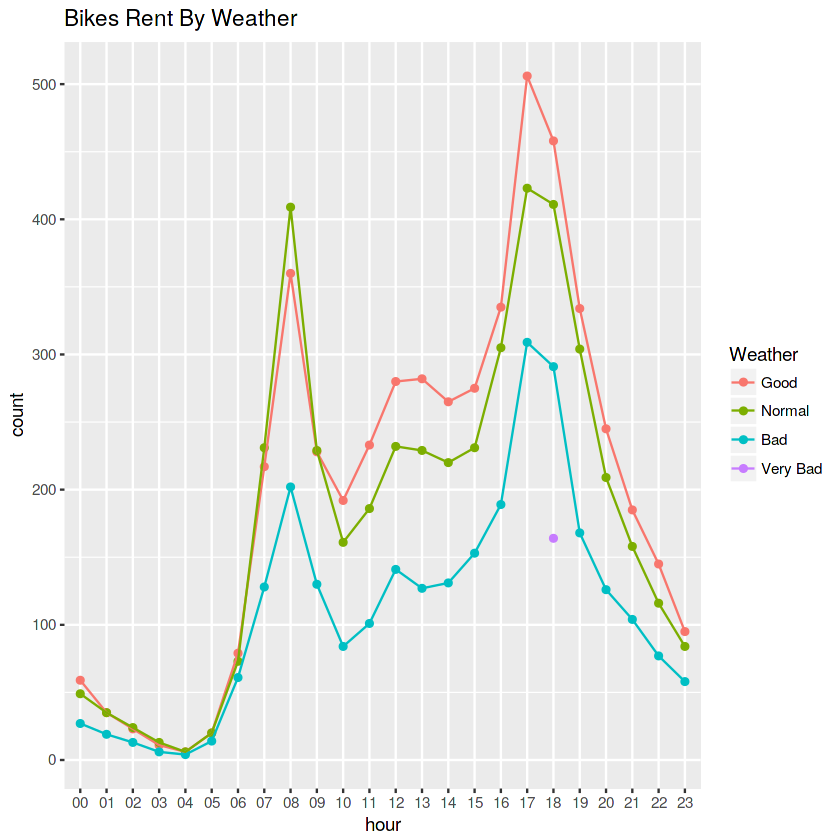

In [4]:
# Get the average count of bikes rent by weather, hour
weather_summary_by_hour <- sqldf('select weather, hour, avg(count) as count from bike_share_train group by weather, hour')

# From this plot it shows, 
# People rent bikes more when weather is good
# We see bike rent only at 18th hour when weather is very bad
ggplot(bike_share_train, aes(x=hour, y=count, color=weather))+geom_point(data = weather_summary_by_hour, aes(group = weather))+geom_line(data = weather_summary_by_hour, aes(group = weather))+ggtitle("Bikes Rent By Weather")+ scale_colour_hue('Weather',breaks = levels(bike_share_train$weather), labels=c('Good', 'Normal', 'Bad', 'Very Bad'))

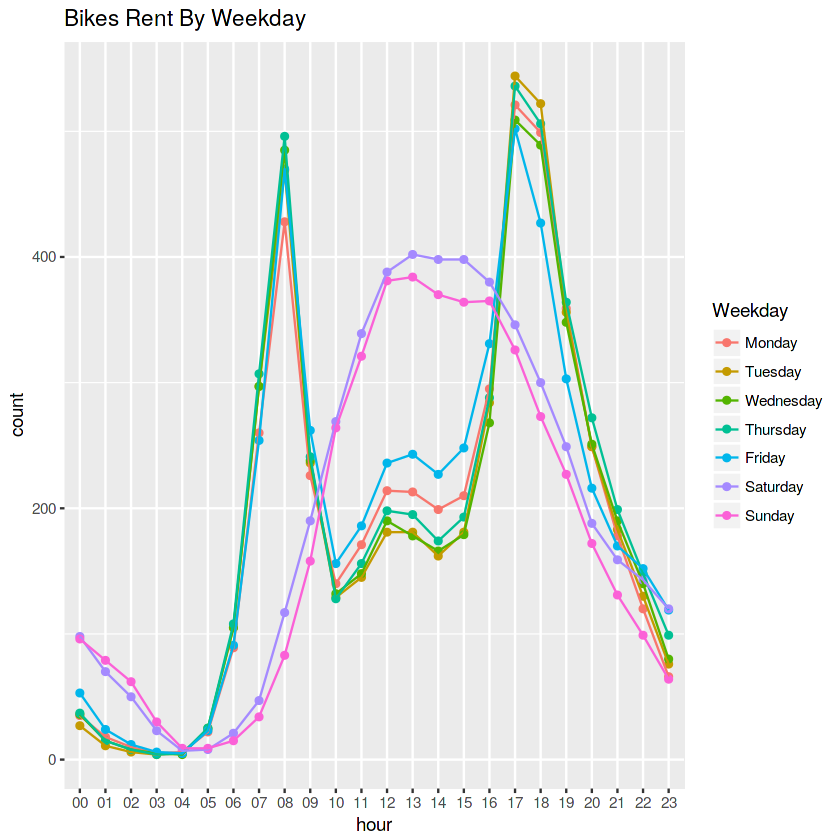

In [5]:
# Get the average count of bikes rent by day, hour
day_summary_by_hour <- sqldf('select day, hour, avg(count) as count from bike_share_train group by day, hour')

# From this plot it shows, 
# There are more bikes rent on weekdays during morining and evening
# There are more bikes rent on weekends during daytime
ggplot(bike_share_train, aes(x=hour, y=count, color=day))+geom_point(data = day_summary_by_hour, aes(group = day))+geom_line(data = day_summary_by_hour, aes(group = day))+ggtitle("Bikes Rent By Weekday")+ scale_colour_hue('Weekday',breaks = levels(bike_share_train$day), labels=c('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

**Correlation Analysis**

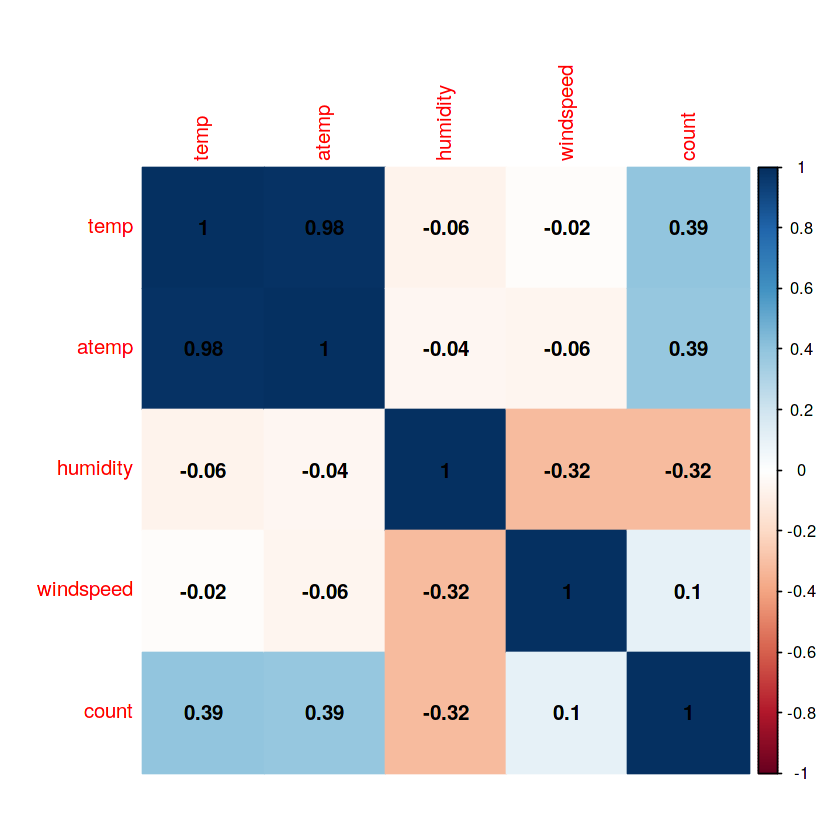

In [6]:
# Correlation plot between fields
# It shows that temp, atemp has much correlation
bike_share_train_subset <- bike_share_train[,5:9]
bike_share_train_subset$humidity <- as.numeric(bike_share_train_subset$humidity)
bike_share_train_subset$count <- as.numeric(bike_share_train_subset$count)

train_cor <- cor(bike_share_train_subset)
library(corrplot)
corrplot(train_cor, method = 'color', addCoef.col="black")

**Splitting the Train dataset**

In [7]:
# Splitting the Train dataset
library(caTools)
set.seed(123)
split <- sample.split(bike_share_train$count, SplitRatio = 0.75)
training_set <- subset(bike_share_train, split == TRUE)
validation_set <- subset(bike_share_train, split == FALSE)

**Model Prediction**

In [8]:
# Applying Linear Regression model
lmBikeRent <- lm(count~., data = training_set)
summary(lmBikeRent)



Call:
lm(formula = count ~ ., data = training_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-364.08  -62.33  -10.28   51.80  493.98 

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -44.52933    9.99478  -4.455 8.49e-06 ***
season2       35.41653    4.62847   7.652 2.21e-14 ***
season3       18.77965    5.91522   3.175 0.001505 ** 
season4       67.87210    3.82050  17.765  < 2e-16 ***
holiday1       2.14896    7.97014   0.270 0.787454    
workingday1    5.33570    4.77772   1.117 0.264118    
weather2      -6.77323    3.05677  -2.216 0.026732 *  
weather3     -64.16092    5.22298 -12.284  < 2e-16 ***
weather4    -130.75829  112.67585  -1.160 0.245887    
temp           4.36904    1.01194   4.317 1.60e-05 ***
atemp          2.34151    0.88869   2.635 0.008435 ** 
humidity      -0.94177    0.08795 -10.708  < 2e-16 ***
windspeed     -0.63558    0.16996  -3.740 0.000186 ***
day2           4.07026    4.

**Residual Plots**

Warning message:
“not plotting observations with leverage one:
  4200”Warning message:
“not plotting observations with leverage one:
  4200”

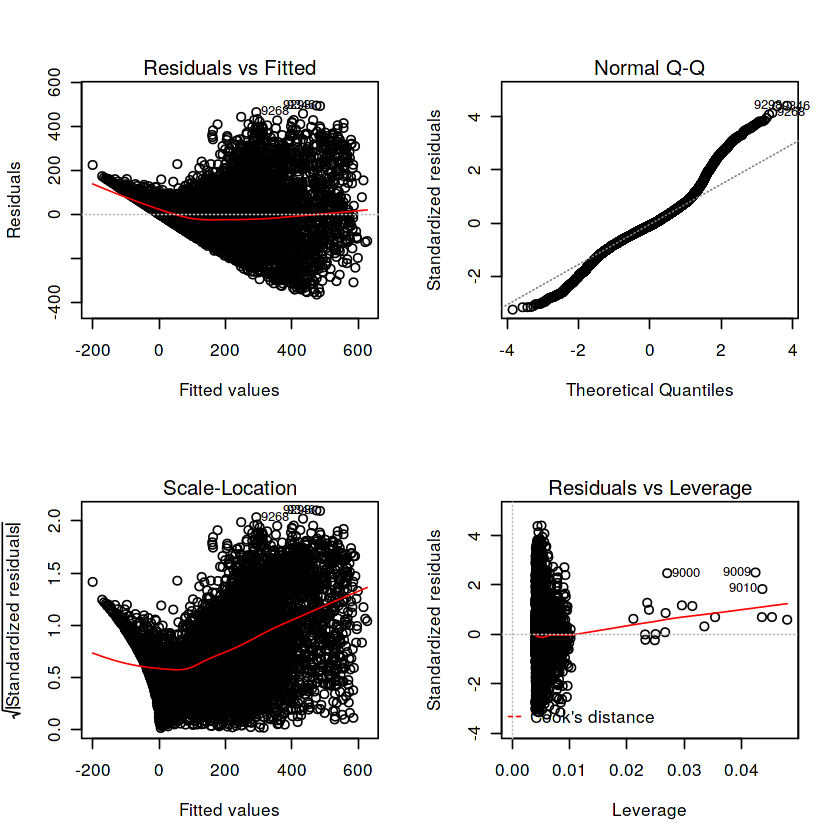

In [9]:
# Change the panel layout to 2 x 2
par(mfrow = c(2, 2))
# Diagnostic Plots
# Residuals vs Fitted: This plot shows if residuals have non-linear patterns.If you find equally spread residuals around a horizontal line without distinct patterns, that is a good indication you don't have non-linear relationships. 
# Normal Q-Q: This plot shows if residuals are normally distributed.Do residuals follow a straight line well or do they deviate severely? It's good if residuals are lined well on the straight dashed line.
# Scale-Location: It's also called Spread-Location plot. This plot shows if residuals are spread equally along the ranges of predictors. This is how you can check the assumption of equal variance (homoscedasticity). It's good if you see a horizontal line with equally (randomly) spread points.
# Residuals vs Leverage: This plot helps us to find influential cases(outliers) if any. Check if any points fall outside of a dashed line, Cook's distance(meaning they have high Cook's distance score).Those outside points are influential to the regression results.The regression results will be altered if we exclude those cases.
# From plots, it shows there is a pattern at one location as highlighted in plots with green color.
plot(lmBikeRent)

**Stepwise Model Selection**

In [10]:
# Now performs stepwise model selection by AIC with both directions(Forward, Backward)
library(MASS)
lmBikeRentAIC<-stepAIC(lmBikeRent, direction="both")
summary(lmBikeRentAIC)

Start:  AIC=77514.76
count ~ season + holiday + workingday + weather + temp + atemp + 
    humidity + windspeed + day + hour


Step:  AIC=77514.76
count ~ season + holiday + weather + temp + atemp + humidity + 
    windspeed + day + hour

            Df Sum of Sq       RSS   AIC
- holiday    1      2134 103059123 77513
<none>                   103056989 77515
- atemp      1     87643 103144632 77520
- windspeed  1    176557 103233545 77527
- day        6    336228 103393217 77529
- temp       1    235337 103292326 77531
- humidity   1   1447691 104504680 77627
- weather    3   1937244 104994233 77662
- season     3   4849413 107906402 77886
- hour      23 102698139 205755127 83141

Step:  AIC=77512.93
count ~ season + weather + temp + atemp + humidity + windspeed + 
    day + hour

             Df Sum of Sq       RSS   AIC
<none>                    103059123 77513
+ holiday     1      2134 103056989 77515
+ workingday  1      2134 103056989 77515
- atemp       1     88823 103147946 775


Call:
lm(formula = count ~ season + weather + temp + atemp + humidity + 
    windspeed + day + hour, data = training_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-364.10  -62.36  -10.18   51.90  494.48 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -39.78081   10.07364  -3.949 7.91e-05 ***
season2       35.43446    4.62803   7.656 2.13e-14 ***
season3       18.74603    5.91435   3.170 0.001532 ** 
season4       67.85509    3.82008  17.763  < 2e-16 ***
weather2      -6.77836    3.05659  -2.218 0.026608 *  
weather3     -64.15204    5.22267 -12.283  < 2e-16 ***
weather4    -130.24171  112.66311  -1.156 0.247704    
temp           4.35568    1.01137   4.307 1.68e-05 ***
atemp          2.35550    0.88800   2.653 0.008003 ** 
humidity      -0.94179    0.08794 -10.709  < 2e-16 ***
windspeed     -0.63564    0.16995  -3.740 0.000185 ***
day2           4.58320    4.65488   0.985 0.324849    
day3          10.83669    4.66202   2.324 0.020125 * 

**Prediction on Validation set**

In [11]:
# Apply prediction on validation set
lm_predict_validation <- predict(lmBikeRentAIC, newdata = validation_set)

#Lets compute the root-mean-square error value between actual and predicted
library(Metrics)
validaion_rmse<-rmse(validation_set$count,lm_predict_validation)
print("root-mean-square error between actual and predicted")
print(validaion_rmse)

# Let's check the summary of predicted count values
cat("\n")
print("summary of predicted count values")
summary(lm_predict_validation)

# summary of actual count values
print("summary of actual count values")
summary(validation_set$count)



[1] "root-mean-square error between actual and predicted"
[1] 102.8466

[1] "summary of predicted count values"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-162.54   74.64  189.95  191.86  294.82  634.53 

[1] "summary of actual count values"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    41.0   141.0   181.4   276.0   839.0 

In [12]:
# From above summary we saw negative values of predicted count.
# We don't want negative values as forecast for bike count. Replace all negative numbers with 1 
Output2Mod <- lm_predict_validation
Output2Mod[lm_predict_validation<=0] <-1

# Check again the summary of predicted count values
print("summary of predicted count values after replaced the negative values")
summary(Output2Mod)

# As we replaced the negative values, the rmse value got reduced
print("root-mean-square error value after replaced the negative values")
print(rmse(validation_set$count,Output2Mod))

cat("\n")
#If we want to penalize under-prediction of demand, rmsle might be a better metric
validaion_rmsle<-rmsle(validation_set$count,Output2Mod)
print("root-mean-square-log error value after replaced the negative values")
print(validaion_rmsle)

[1] "summary of predicted count values after replaced the negative values"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0046  74.6357 189.9530 195.9799 294.8231 634.5262 

[1] "root-mean-square error value after replaced the negative values"
[1] 100.8923

[1] "root-mean-square-log error value after replaced the negative values"
[1] 0.9549201


**Log Transformation**

In [13]:
# Since we got negative predicted values, let's do log transformation and run regression model again
lmBikeRentLog <- lm(log(count)~., data = training_set)

# Now performs stepwise model selection on log model
lmBikeRentLogAIC <- stepAIC(lmBikeRentLog, direction="both")

lm_predict_validation_log <- predict(lmBikeRentLogAIC,newdata=validation_set)

# As the predicted values are in log format, use exponential(exp) to convert from log to non-log values
lm_predict_validation_nonlog <- exp(lm_predict_validation_log)


Start:  AIC=-6582.08
log(count) ~ season + holiday + workingday + weather + temp + 
    atemp + humidity + windspeed + day + hour


Step:  AIC=-6582.08
log(count) ~ season + holiday + weather + temp + atemp + humidity + 
    windspeed + day + hour

            Df Sum of Sq     RSS     AIC
- holiday    1       0.1  3641.3 -6583.9
<none>                    3641.2 -6582.1
- atemp      1       3.2  3644.4 -6577.0
- windspeed  1       8.7  3650.0 -6564.4
- temp       1       8.9  3650.1 -6564.1
- humidity   1      17.0  3658.3 -6545.8
- day        6      44.6  3685.9 -6494.1
- weather    3     141.4  3782.6 -6275.6
- season     3     312.8  3954.0 -5912.1
- hour      23    9526.8 13168.1  3917.9

Step:  AIC=-6583.92
log(count) ~ season + weather + temp + atemp + humidity + windspeed + 
    day + hour

             Df Sum of Sq     RSS     AIC
<none>                     3641.3 -6583.9
+ holiday     1       0.1  3641.2 -6582.1
+ workingday  1       0.1  3641.2 -6582.1
- atemp       1       3.

In [14]:
# Let's check the summary of predicted count values, it shows there are no negative values
print("summary of predicted count values after log transformation")
summary(lm_predict_validation_nonlog)

# Check rmsle value again, it got reduced from 0.9549201 to 0.6278527
validaion_nonlog_rmsle<-rmsle(validation_set$count,lm_predict_validation_nonlog)
print("root-mean-square-log error value after log transformation")
print(validaion_nonlog_rmsle)

[1] "summary of predicted count values after log transformation"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.643   45.555  141.368  170.248  259.791 1063.565 

[1] "root-mean-square-log error value after log transformation"
[1] 0.6278527


**Residual vs Fitted plot**

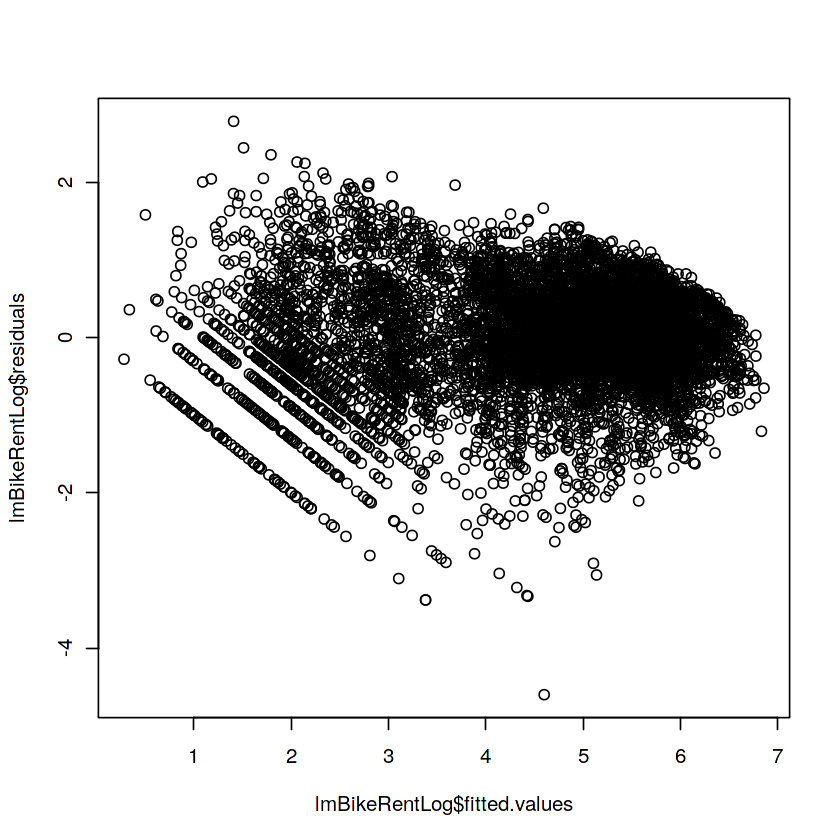

In [15]:
# Let's check the Residual vs Fitted plot
# It shows some points forms a straight lines
# If you select bottom straight line points using "identify", you will find that the bike rent count is 1
# and next straight line points will have bike rent count of 2. 
plot(lmBikeRentLog$fitted.values, lmBikeRentLog$residuals)

**Run the final model with Test data**

In [16]:
# Run model on test data
lm_predict_test_log <- predict(lmBikeRentLogAIC,newdata=bike_share_test)

# As the predicted values are in log format, use exponential(exp) to convert from log to non-log values
lm_predict_test_nonlog <- exp(lm_predict_test_log)

final_df <- cbind(as.data.frame(lm_predict_test_nonlog), bike_share_test$datetime)
colnames(final_df) <- c("count", "datetime")
final_df

count,datetime
21.730865,2011-01-20 00:00:00
12.726650,2011-01-20 01:00:00
7.294767,2011-01-20 02:00:00
4.165179,2011-01-20 03:00:00
3.030784,2011-01-20 04:00:00
8.251764,2011-01-20 05:00:00
26.745412,2011-01-20 06:00:00
76.276449,2011-01-20 07:00:00
138.593604,2011-01-20 08:00:00
101.833515,2011-01-20 09:00:00
